# XCEPTION + DEC Model on Galaxy Zoo Dataset

This notebook loads the xception model and tries to extract features from the Xception Model for all the galaxy zoo images. Then it invokes a DEC model on top of the features extracted to perform the required clustering. This notebook acts as a step by step guide through the whole process and also as a way of performing the experiment for the current research of clustering galaxies.

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [3]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [5]:
input_tensor_shape = (150, 150, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 224 X 224 X 3. That is a 3 channel square image with side 224 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Loading the Galaxy Zoo data

We now start loading the galaxy zoo data into memory. First we load the label file and then start loading the corresponding images such that we can assign the corresponding label to them

In [6]:
all_labels = pd.read_csv(f'../data/galaxy_zoo/training_solutions_rev1.csv')
all_labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
# Assuming the follwing column names:
elliptical_galaxy_col_name = 'Class1.1'
spiral_galaxy_col_name = 'Class1.2'

# elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] > all_labels[spiral_galaxy_col_name]]['GalaxyID'], dtype=str)
elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] >= 0.5]['GalaxyID'], dtype=str)
# spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > all_labels[elliptical_galaxy_col_name]]['GalaxyID'], dtype=str)
spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > 0.5]['GalaxyID'], dtype=str)

In [8]:
# Finding the number of images for each type of galaxy
print(f'Number Elliptical Galaxies: {elliptical_galaxy_ids.shape[0]}')
print(f'Number Spiral Galaxies: {spiral_galaxy_ids.shape[0]}')

Number Elliptical Galaxies: 25868
Number Spiral Galaxies: 34105


### Elliptical Galaxy

#### Visualization

In [9]:
elliptical_galaxy_ids.head()

2    100053
3    100078
4    100090
5    100122
7    100128
Name: GalaxyID, dtype: object

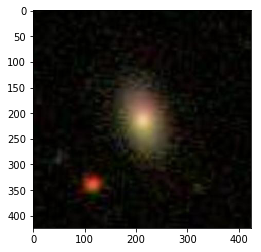

In [10]:
# Not using cv2 because it reads the image channels in a reverse order (BGR instead of RGB)
# elliptical_image = cv2.imread(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100053.jpg')
elliptical_image = Image.open(f'../data/galaxy_zoo/images_training_rev1/100053.jpg')
plt.imshow(elliptical_image)

#### Features from the model

In [11]:
# First finding the input shape of the image
print(f'Original Image Size: {np.array(elliptical_image).shape}')
ellip_image_arr = resize(np.array(elliptical_image), input_tensor_shape)
print(f'Resized Image Size: {ellip_image_arr.shape}')

Original Image Size: (424, 424, 3)
Resized Image Size: (150, 150, 3)


In [12]:
%%time
ellip_predications = base_xception_model.predict(ellip_image_arr.reshape((-1,) + input_tensor_shape))
print(ellip_predications)

[[0.12479405 0.         0.         ... 0.34131664 0.00561014 0.        ]]
CPU times: user 1.45 s, sys: 396 ms, total: 1.85 s
Wall time: 2.86 s


### Spiral Galaxy

#### Visualization

In [13]:
spiral_galaxy_ids.head()

0     100008
1     100023
8     100134
9     100143
10    100150
Name: GalaxyID, dtype: object

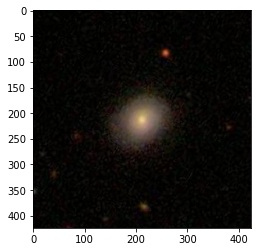

In [14]:
# Not using cv2 because it reads the image channels in a reverse order (BGR instead of RGB)
# spiral_image = cv2.imread(f'../data/galaxy_zoo/galaxy-zoo-the-galaxy-challenge/images_training_rev1/images_training_rev1/100008.jpg')
spiral_image = Image.open(f'../data/galaxy_zoo/images_training_rev1/100008.jpg')
plt.imshow(spiral_image)

#### Features from the model

In [15]:
# First finding the input shape of the image
print(f'Original Image Size: {np.array(spiral_image).shape}')
spiral_image_arr = resize(np.array(spiral_image), input_tensor_shape)
print(f'Resized Image Size: {spiral_image_arr.shape}')

Original Image Size: (424, 424, 3)
Resized Image Size: (150, 150, 3)


In [16]:
%%time
spiral_predications = base_xception_model.predict(spiral_image_arr.reshape((-1,) + input_tensor_shape))
print(spiral_predications)

[[0.01227139 0.         0.         ... 0.07426    0.         0.        ]]
CPU times: user 44 ms, sys: 20 ms, total: 64 ms
Wall time: 21.3 ms


### Data Validation

Validate whether all the images are in the required place of the training and the testing directories. Make sure we copy all the required images from the galaxy zoo data lake to the correct place and then define all the generators

In [17]:
data_lake_path = f'../data/galaxy_zoo/images_training_rev1/'
print(exist_directory(data_lake_path))
training_directory_path = f'../data/xception_clustering/training/'
testing_directory_path = f'../data/xception_clustering/testing/'
print(exist_directory(training_directory_path), exist_directory(testing_directory_path))

True
True True


In [18]:
# Get file names for the different types of galaxies from the dataframe that are also present in the dataset
image_extension = '.jpg'
all_image_files = get_file_nms(data_lake_path, image_extension)
print(len(all_image_files))
common_spiral_galaxy_ids = list(set(spiral_galaxy_ids).intersection(all_image_files))
common_elliptical_galaxy_ids = list(set(elliptical_galaxy_ids).intersection(all_image_files))
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of common Elliptical Galaxies: {len(common_elliptical_galaxy_ids)}')
print(f'Number of common Spiral Galaxies: {len(common_spiral_galaxy_ids)}')

61578
Number of common Elliptical Galaxies: 25868
Number of common Spiral Galaxies: 34105


In [19]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Testing Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Testing Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 25868
Number of already present Training Spiral Galaxies: 34105
Number of already present Testing Elliptical Galaxies: 0
Number of already present Testing Spiral Galaxies: 0


In [19]:
# Splitting the data into training and testing split
train_galaxy_ids_elliptical, test_galaxy_ids_elliptical = train_test_split(common_elliptical_galaxy_ids, test_size=0.)
train_galaxy_ids_spiral, test_galaxy_ids_spiral = train_test_split(common_spiral_galaxy_ids, test_size=0.)

In [20]:
len(train_galaxy_ids_elliptical), len(train_galaxy_ids_spiral)

(25868, 34105)

In [30]:
%%time
# Iterating to copy the data
for file_name in set(train_galaxy_ids_elliptical) - elliptical_training_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(elliptical_training_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Training Elliptical Files Copied!')

for file_name in set(test_galaxy_ids_elliptical) - elliptical_testing_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(elliptical_testing_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Testing Elliptical Files Copied!')

for file_name in set(train_galaxy_ids_spiral) - spiral_training_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(spiral_training_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Training Spiral Files Copied!')

for file_name in set(test_galaxy_ids_spiral) - spiral_testing_files:
    input_file_path = construct_path(data_lake_path, f'{file_name}{image_extension}')
    outut_file_path = construct_path(spiral_testing_directory_path, f'{file_name}{image_extension}')
    copy2(input_file_path, outut_file_path)
print('Testing Spiral Files Copied!')

Hello
Hello
Hello
CPU times: user 3.04 s, sys: 2.98 s, total: 6.02 s
Wall time: 6.82 s


### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

#### Featurewise Centering Data Generation

In [23]:
%%time
generator_batch_size = 64
image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3 s, sys: 820 ms, total: 3.82 s
Wall time: 2.75 s


In [25]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i * generator_batch_size >= n_train_examples:
        break

CPU times: user 11min 21s, sys: 3min 40s, total: 15min 1s
Wall time: 14min 8s


In [26]:
train_features.shape

(59968, 2048)

In [54]:
# other type of feature generation
#%%time
#number_training_samples = len(training_generator.filenames)
#number_testing_samples = len(testing_generator.filenames)
#train_features = base_xception_model.predict_generator(training_generator, steps=10)

#### -1 to 1 Range Data Generation along with Cropping

In [20]:
def get_difference(orig_size, target_size):
    orig_size, target_size = list(orig_size), list(target_size)
    ret_ls = []
    for o, t in zip(orig_size, target_size):
        ret_ls.append(o - t)
    return ret_ls

def crop_image(image, orig_size, target_size):
    crop_sizes = get_difference(orig_size, target_size)
    height_dif, width_dif = crop_sizes[0] // 2, crop_sizes[1] // 2
    return image[height_dif:(height_dif + target_size[0]), width_dif:(width_dif + target_size[1]), :]

def range_scaling(image):
    old_min, old_max = 0., 255.
    new_min, new_max = -1., 1.
    return ((image - old_min)/(old_max - old_min))*(new_max - new_min) + new_min

def image_preprocessing_function(image):
    """
    image is a 3-D image tensor (numpy array).
    """
    target_image_size = input_tensor_shape
    cropped_image = crop_image(image, image.shape, target_image_size)
    return range_scaling(cropped_image)

In [21]:
%%time
generator_batch_size = 128
image_generator = ImageDataGenerator(preprocessing_function=image_preprocessing_function)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 3.47 s, sys: 736 ms, total: 4.2 s
Wall time: 2.97 s


In [22]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i % 10 == 0:
        print('Number of images processed:', i * generator_batch_size)
    if i * generator_batch_size >= n_train_examples:
        break

Number of images processed: 1280
Number of images processed: 2560
Number of images processed: 3840
Number of images processed: 5120
Number of images processed: 6400
Number of images processed: 7680
Number of images processed: 8960
Number of images processed: 10240
Number of images processed: 11520
Number of images processed: 12800
Number of images processed: 14080
Number of images processed: 15360
Number of images processed: 16640
Number of images processed: 17920
Number of images processed: 19200
Number of images processed: 20480
Number of images processed: 21760
Number of images processed: 23040
Number of images processed: 24320
Number of images processed: 25600
Number of images processed: 26880
Number of images processed: 28160
Number of images processed: 29440
Number of images processed: 30720
Number of images processed: 32000
Number of images processed: 33280
Number of images processed: 34560
Number of images processed: 35840
Number of images processed: 37120
Number of images proc

In [60]:
train_features.shape

(59968, 2048)

In [38]:
# %%time
# number_training_samples = len(training_generator.filenames)
# number_testing_samples = len(testing_generator.filenames)
# train_features = base_xception_model.predict_generator(training_generator, steps=number_training_samples)

CPU times: user 10.8 s, sys: 3.4 s, total: 14.2 s
Wall time: 9.41 s


### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [61]:
# Defining our DEC model
dec_model = DEC([2048, 500, 500, 2000, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [62]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 90us/step - loss: 0.0151
        |==>  acc: 0.6922,  nmi: 0.1101  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0079
Epoch 3/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0070
Epoch 4/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.0067
Epoch 5/100
59968/59968 [==============================] - 4s 73us/step - loss: 0.0065
Epoch 6/100
59968/59968 [==============================] - 4s 72us/step - loss: 0.0064
Epoch 7/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0062
Epoch 8/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0062
Epoch 9/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0061
Epoch 10/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0060
Epoch 11/100
59968/59968 [==============================] - 4s 69

In [63]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.68558, nmi = 0.09598, ari = 0.13746  ; loss= 0
saving model to: ./results/temp/DEC_model_0.h5
Iter 140: acc = 0.68235, nmi = 0.09517, ari = 0.13288  ; loss= 0.00087
Iter 280: acc = 0.67828, nmi = 0.09266, ari = 0.12708  ; loss= 0.00182
Iter 420: acc = 0.67781, nmi = 0.09330, ari = 0.12643  ; loss= 0.00913
Iter 560: acc = 0.67865, nmi = 0.09427, ari = 0.12762  ; loss= 0.02963
Iter 700: acc = 0.67926, nmi = 0.09502, ari = 0.12851  ; loss= 0.03607
Iter 840: acc = 0.68046, nmi = 0.09616, ari = 0.13023  ; loss= 0.03411
Iter 980: acc = 0.67761, nmi = 0.09424, ari = 0.12616  ; loss= 0.03654
Iter 1120: acc = 0.67836, nmi = 0.09454, ari = 0.12723  ; loss= 0.0329
Iter 1260: acc = 0.67816, nmi = 0.09441, ari = 0.12694  ; loss= 0.03163
Iter 1400: acc = 0.67776, nmi = 0.09465, ari = 0.12638  ; loss= 0.03368
Iter 1540: acc = 0.67651, nmi = 0.09355, ari = 0.12461  ; loss= 0.02643
Iter 1680: acc = 0.67451

Iter 15680: acc = 0.65295, nmi = 0.07252, ari = 0.09354  ; loss= 0.00828
Iter 15820: acc = 0.65322, nmi = 0.07277, ari = 0.09387  ; loss= 0.00775
Iter 15960: acc = 0.65175, nmi = 0.07211, ari = 0.09207  ; loss= 0.00974
Iter 16100: acc = 0.65238, nmi = 0.07245, ari = 0.09285  ; loss= 0.00711
Iter 16240: acc = 0.65328, nmi = 0.07264, ari = 0.09396  ; loss= 0.00983
Iter 16380: acc = 0.65056, nmi = 0.07107, ari = 0.09064  ; loss= 0.00901
Iter 16520: acc = 0.65166, nmi = 0.07160, ari = 0.09198  ; loss= 0.01064
Iter 16660: acc = 0.65120, nmi = 0.07136, ari = 0.09141  ; loss= 0.00733
Iter 16800: acc = 0.65120, nmi = 0.07102, ari = 0.09141  ; loss= 0.00733
Iter 16940: acc = 0.64970, nmi = 0.07053, ari = 0.08959  ; loss= 0.00699
Iter 17080: acc = 0.65190, nmi = 0.07225, ari = 0.09225  ; loss= 0.00704
Iter 17220: acc = 0.65342, nmi = 0.07291, ari = 0.09412  ; loss= 0.00673
Iter 17360: acc = 0.65407, nmi = 0.07332, ari = 0.09492  ; loss= 0.00796
Iter 17500: acc = 0.65547, nmi = 0.07378, ari = 0.0

### Visualization of the features extracted by the DEC model

#### Clustering Output Features

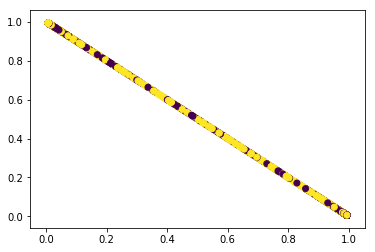

In [64]:
dec_whole_model_pred = dec_model.model.predict(train_features)
plt.scatter(dec_whole_model_pred[:, 0], dec_whole_model_pred[:, 1], c=train_labels)
plt.savefig(f'../data/figs/clustering_features_new_shape_1.png')

#### Encoder Output Features

CPU times: user 6.81 s, sys: 1.32 s, total: 8.14 s
Wall time: 6.02 s


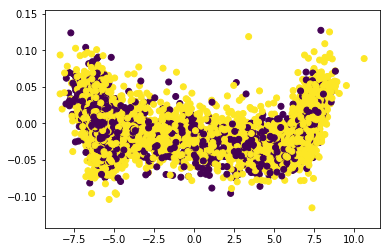

In [65]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
from sklearn.decomposition import PCA
pca_mod = PCA(2)
reduced_features = pca_mod.fit_transform(dec_encoder_model_pred)
#cond_arr = (reduced_features[:, 0] < 50) & (reduced_features[:, 1] < 6)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels)
plt.savefig(f'../data/figs/encoding_pca_features_new_shape_1.png')

#### -1 to 1 Range Data Generation along with Cropping - Round 2

This time I am changing the shape of the DEC Architecture

In [66]:
# Defining our DEC model
dec_model = DEC([2048, 1024, 1024], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
encoder_1 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 2048      
Total params: 3,149,824
Trainable params: 3,149,824
Non-trainable params: 0
_________________________________________________________________


In [67]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 5s 87us/step - loss: 0.0086
        |==>  acc: 0.6682,  nmi: 0.0835  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 67us/step - loss: 0.0037
Epoch 3/100
59968/59968 [==============================] - 4s 65us/step - loss: 0.0029
Epoch 4/100
59968/59968 [==============================] - 4s 65us/step - loss: 0.0025
Epoch 5/100
59968/59968 [==============================] - 4s 65us/step - loss: 0.0022
Epoch 6/100
59968/59968 [==============================] - 4s 66us/step - loss: 0.0021
Epoch 7/100
59968/59968 [==============================] - 4s 66us/step - loss: 0.0019
Epoch 8/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0037
Epoch 9/100
59968/59968 [==============================] - 4s 69us/step - loss: 0.0021
Epoch 10/100
59968/59968 [==============================] - 4s 68us/step - loss: 0.0019
Epoch 11/100
59968/59968 [==============================] - 4s 68

In [68]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.67845, nmi = 0.09505, ari = 0.12735  ; loss= 0
saving model to: ./results/temp/DEC_model_0.h5
Iter 140: acc = 0.67784, nmi = 0.09492, ari = 0.12650  ; loss= 0.00116
Iter 280: acc = 0.67906, nmi = 0.09613, ari = 0.12824  ; loss= 0.0031
Iter 420: acc = 0.68076, nmi = 0.09768, ari = 0.13068  ; loss= 0.01239
Iter 560: acc = 0.68276, nmi = 0.09918, ari = 0.13358  ; loss= 0.02313
Iter 700: acc = 0.68452, nmi = 0.10069, ari = 0.13615  ; loss= 0.03446
Iter 840: acc = 0.68380, nmi = 0.10100, ari = 0.13511  ; loss= 0.03762
Iter 980: acc = 0.68011, nmi = 0.09952, ari = 0.12975  ; loss= 0.04017
Iter 1120: acc = 0.68086, nmi = 0.09994, ari = 0.13083  ; loss= 0.04031
Iter 1260: acc = 0.68508, nmi = 0.10269, ari = 0.13700  ; loss= 0.04662
Iter 1400: acc = 0.68430, nmi = 0.10310, ari = 0.13585  ; loss= 0.04162
Iter 1540: acc = 0.68462, nmi = 0.10361, ari = 0.13632  ; loss= 0.03384
Iter 1680: acc = 0.68468

Iter 15680: acc = 0.69112, nmi = 0.11252, ari = 0.14609  ; loss= 0.01725
Iter 15820: acc = 0.68892, nmi = 0.11160, ari = 0.14273  ; loss= 0.03534
Iter 15960: acc = 0.68848, nmi = 0.11090, ari = 0.14208  ; loss= 0.02269
Iter 16100: acc = 0.68860, nmi = 0.11118, ari = 0.14225  ; loss= 0.02588
Iter 16240: acc = 0.68952, nmi = 0.11169, ari = 0.14364  ; loss= 0.01672
Iter 16380: acc = 0.69197, nmi = 0.11335, ari = 0.14739  ; loss= 0.01406
Iter 16520: acc = 0.69249, nmi = 0.11343, ari = 0.14819  ; loss= 0.01833
Iter 16660: acc = 0.69144, nmi = 0.11265, ari = 0.14657  ; loss= 0.01487
Iter 16800: acc = 0.69309, nmi = 0.11375, ari = 0.14912  ; loss= 0.01928
Iter 16940: acc = 0.69257, nmi = 0.11376, ari = 0.14832  ; loss= 0.02253
Iter 17080: acc = 0.69387, nmi = 0.11421, ari = 0.15033  ; loss= 0.03331
Iter 17220: acc = 0.69309, nmi = 0.11415, ari = 0.14911  ; loss= 0.01925
Iter 17360: acc = 0.69352, nmi = 0.11478, ari = 0.14979  ; loss= 0.01892
Iter 17500: acc = 0.69497, nmi = 0.11528, ari = 0.1

#### Clustering Output Features

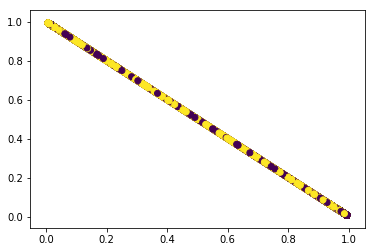

In [69]:
dec_whole_model_pred = dec_model.model.predict(train_features)
plt.scatter(dec_whole_model_pred[:, 0], dec_whole_model_pred[:, 1], c=train_labels)
plt.savefig(f'../data/figs/clustering_features_new_shape_2.png')

#### Encoder Output Features

CPU times: user 10.3 s, sys: 1.37 s, total: 11.7 s
Wall time: 8.24 s


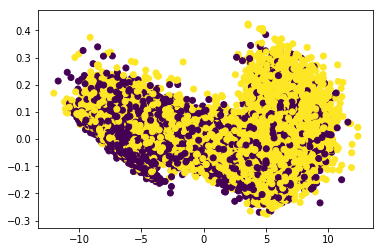

In [70]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
from sklearn.decomposition import PCA
pca_mod = PCA(2)
reduced_features = pca_mod.fit_transform(dec_encoder_model_pred)
#cond_arr = (reduced_features[:, 0] < 50) & (reduced_features[:, 1] < 6)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels)
plt.savefig(f'../data/figs/encoding_pca_features_new_shape_2.png')

#### -1 to 1 Range Data Generation along with Cropping - Round 3

This time I am changing the shape of the DEC Architecture one more time

In [35]:
# Defining our DEC model
dec_model = DEC([2048, 1024, 512, 512, 256], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
encoder_1 (Dense)            (None, 512)               524800    
_________________________________________________________________
encoder_2 (Dense)            (None, 512)               262656    
_________________________________________________________________
encoder_3 (Dense)            (None, 256)               131328    
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 512       
Total params: 3,017,472
Trainable params: 3,017,472
Non-trainable params: 0
_________________________________________________________________


In [36]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=200)

...Pretraining...
Epoch 1/200
59968/59968 [==============================] - 6s 93us/step - loss: 0.0083
        |==>  acc: 0.6968,  nmi: 0.1407  <==|
Epoch 2/200
59968/59968 [==============================] - 5s 75us/step - loss: 0.0039
Epoch 3/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.0032
Epoch 4/200
59968/59968 [==============================] - 4s 73us/step - loss: 0.0028
Epoch 5/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.0026
Epoch 6/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.0024
Epoch 7/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.0023
Epoch 8/200
59968/59968 [==============================] - 4s 75us/step - loss: 0.0022
Epoch 9/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.0021
Epoch 10/200
59968/59968 [==============================] - 4s 74us/step - loss: 0.0020
Epoch 11/200
59968/59968 [==============================] - 4s 73

59968/59968 [==============================] - 4s 71us/step - loss: 0.0011
Epoch 181/200
59968/59968 [==============================] - 4s 72us/step - loss: 9.8533e-04
        |==>  acc: 0.5900,  nmi: 0.0219  <==|
Epoch 182/200
59968/59968 [==============================] - 4s 74us/step - loss: 9.7370e-04
Epoch 183/200
59968/59968 [==============================] - 4s 73us/step - loss: 9.8032e-04
Epoch 184/200
59968/59968 [==============================] - 4s 73us/step - loss: 9.5104e-04
Epoch 185/200
59968/59968 [==============================] - 4s 73us/step - loss: 9.6884e-04
Epoch 186/200
59968/59968 [==============================] - 4s 72us/step - loss: 9.6668e-04
Epoch 187/200
59968/59968 [==============================] - 4s 71us/step - loss: 0.0011
Epoch 188/200
59968/59968 [==============================] - 4s 71us/step - loss: 9.9550e-04
Epoch 189/200
59968/59968 [==============================] - 4s 72us/step - loss: 0.0010
Epoch 190/200
59968/59968 [=======================

In [37]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=64)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 4685
Initializing cluster centers with k-means.
Iter 0: acc = 0.51976, nmi = 0.00145, ari = 0.00152  ; loss= 0
saving model to: ./results/temp/DEC_model_0.h5
Iter 140: acc = 0.52326, nmi = 0.00167, ari = 0.00215  ; loss= 0.00324
Iter 280: acc = 0.52283, nmi = 0.00160, ari = 0.00207  ; loss= 0.00332
Iter 420: acc = 0.52305, nmi = 0.00161, ari = 0.00211  ; loss= 0.01252
Iter 560: acc = 0.52516, nmi = 0.00184, ari = 0.00252  ; loss= 0.02993
Iter 700: acc = 0.52253, nmi = 0.00162, ari = 0.00201  ; loss= 0.03942
Iter 840: acc = 0.52291, nmi = 0.00167, ari = 0.00208  ; loss= 0.03777
Iter 980: acc = 0.52221, nmi = 0.00160, ari = 0.00195  ; loss= 0.03825
Iter 1120: acc = 0.52590, nmi = 0.00184, ari = 0.00266  ; loss= 0.03477
Iter 1260: acc = 0.52411, nmi = 0.00166, ari = 0.00231  ; loss= 0.0307
Iter 1400: acc = 0.52326, nmi = 0.00162, ari = 0.00215  ; loss= 0.02836
Iter 1540: acc = 0.52398, nmi = 0.00164, ari = 0.00228  ; loss= 0.02673
Iter 1680: acc = 0.52393

Iter 15400: acc = 0.54457, nmi = 0.00390, ari = 0.00763  ; loss= 0.00709
Iter 15540: acc = 0.54337, nmi = 0.00373, ari = 0.00724  ; loss= 0.00889
Iter 15680: acc = 0.54392, nmi = 0.00378, ari = 0.00741  ; loss= 0.01152
Iter 15820: acc = 0.54376, nmi = 0.00376, ari = 0.00736  ; loss= 0.00778
Iter 15960: acc = 0.54671, nmi = 0.00424, ari = 0.00837  ; loss= 0.08085
Iter 16100: acc = 0.54604, nmi = 0.00411, ari = 0.00812  ; loss= 0.00739
Iter 16240: acc = 0.54708, nmi = 0.00421, ari = 0.00846  ; loss= 0.0069
Iter 16380: acc = 0.54693, nmi = 0.00419, ari = 0.00841  ; loss= 0.00718
Iter 16520: acc = 0.54711, nmi = 0.00417, ari = 0.00845  ; loss= 0.0162
Iter 16660: acc = 0.54664, nmi = 0.00410, ari = 0.00829  ; loss= 0.00897
Iter 16800: acc = 0.55086, nmi = 0.00486, ari = 0.00985  ; loss= 0.04496
Iter 16940: acc = 0.54976, nmi = 0.00460, ari = 0.00941  ; loss= 0.00861
Iter 17080: acc = 0.55118, nmi = 0.00484, ari = 0.00994  ; loss= 0.00673
Iter 17220: acc = 0.55149, nmi = 0.00491, ari = 0.010

#### Clustering Output Features

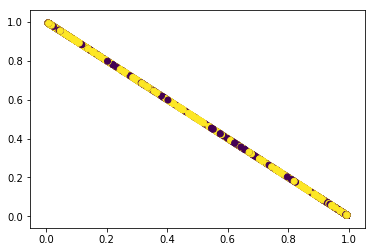

In [38]:
dec_whole_model_pred = dec_model.model.predict(train_features)
plt.scatter(dec_whole_model_pred[:, 0], dec_whole_model_pred[:, 1], c=train_labels)
plt.savefig(f'../data/figs/clustering_features_3.png')

#### Encoder Output Features

CPU times: user 8.04 s, sys: 1.35 s, total: 9.38 s
Wall time: 6.86 s


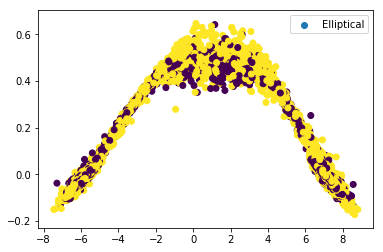

In [41]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
from sklearn.decomposition import PCA
pca_mod = PCA(2)
reduced_features = pca_mod.fit_transform(dec_encoder_model_pred)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels)
plt.legend(['Elliptical', 'Spiral'])
plt.savefig(f'../data/figs/encoding_pca_features_3.png')